# 03 — Backtest Results Analysis (MLP)

This notebook loads **exported backtest CSVs** from the MLP version and produces:

- A results table computed from the equity curve
- Equity curves
- Action distribution (HOLD/BUY/SELL)

**Expected CSV columns:** `Date`, `Close`, `Action`, `Equity`.

Place CSVs in: `versions/mlp/outputs/` (recommended).

## 0) Setup

In [19]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Imports OK")


Imports OK


## 1) Locate backtest CSVs
Adjust `OUT_DIR` if needed.

In [20]:
ROOT = Path('.').resolve().parent
OUT_DIR = ROOT / 'versions' / 'mlp' / 'outputs'

print('Repo root:', ROOT)
print('MLP outputs:', OUT_DIR)

csvs = sorted(OUT_DIR.glob('*.csv'))
print('Found CSVs:', len(csvs))
for p in csvs:
    print('-', p.name)


Repo root: /Users/alessandrofiaschini/Desktop/smart-trader-btc
MLP outputs: /Users/alessandrofiaschini/Desktop/smart-trader-btc/versions/mlp/outputs
Found CSVs: 5
- backtest_2012_2021_mlp.csv
- backtest_2012_2025_mlp.csv
- backtest_2018_2021_mlp.csv
- backtest_2021_2025_mlp.csv
- backtest_2023_2025_mlp.csv


## 2) Load + metrics helper

In [21]:
def load_backtest_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    rename = {}
    for c in df.columns:
        cl = c.strip().lower()
        if cl in {'data', 'date', 'datetime', 'timestamp'}:
            rename[c] = 'Date'
        elif cl == 'close':
            rename[c] = 'Close'
        elif cl == 'action':
            rename[c] = 'Action'
        elif cl in {'equity', 'portfolio', 'portfolio_value', 'value'}:
            rename[c] = 'Equity'
    df = df.rename(columns=rename)

    required = {'Date', 'Close', 'Action', 'Equity'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"{path.name}: missing {missing}. Found: {list(df.columns)}")

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    return df

def compute_metrics(equity: pd.Series) -> dict:
    eq = equity.astype(float).values
    if len(eq) < 2:
        return {'total_return_pct': 0.0, 'sharpe': 0.0, 'max_drawdown_pct': 0.0}

    rets = pd.Series(eq).pct_change().dropna()
    total_return = (eq[-1] / eq[0]) - 1.0

    r_mean = rets.mean()
    r_std = rets.std()
    sharpe = 0.0 if (r_std == 0 or np.isnan(r_std)) else float((r_mean / r_std) * np.sqrt(252))

    running_max = np.maximum.accumulate(eq)
    dd = (eq / running_max) - 1.0
    max_dd = float(dd.min())

    return {
        'total_return_pct': float(total_return * 100.0),
        'sharpe': sharpe,
        'max_drawdown_pct': float(max_dd * 100.0),
    }

def action_distribution(actions: pd.Series) -> dict:
    vc = actions.value_counts().to_dict()
    return {int(k): int(v) for k, v in vc.items()}


## 3) Build results table

In [22]:
rows = []
loaded = {}

for p in csvs:
    df_bt = load_backtest_csv(p)
    loaded[p.name] = df_bt

    m = compute_metrics(df_bt['Equity'])
    ad = action_distribution(df_bt['Action'])

    rows.append({
        'file': p.name,
        'start': df_bt['Date'].iloc[0].date().isoformat(),
        'end': df_bt['Date'].iloc[-1].date().isoformat(),
        'total_return_%': round(m['total_return_pct'], 2),
        'sharpe': round(m['sharpe'], 2),
        'max_drawdown_%': round(m['max_drawdown_pct'], 2),
        'actions_0': ad.get(0, 0),
        'actions_1': ad.get(1, 0),
        'actions_2': ad.get(2, 0),
    })

results = pd.DataFrame(rows).sort_values(['start','end']).reset_index(drop=True)
results


,file,start,end,total_return_%,sharpe,max_drawdown_%,actions_0,actions_1,actions_2
0,backtest_2012_2021_mlp.csv,2014-10-21,2020-12-30,16181.75,1.47,-57.95,731,0,1532
1,backtest_2012_2025_mlp.csv,2014-10-21,2024-12-30,16181.75,1.15,-57.95,2192,0,1532
2,backtest_2018_2021_mlp.csv,2018-02-04,2020-12-30,417.91,1.26,-48.24,640,0,421
3,backtest_2021_2025_mlp.csv,2021-02-04,2024-12-30,0.00,0.00,0.00,1426,0,0
4,backtest_2023_2025_mlp.csv,2023-02-04,2024-12-30,0.00,0.00,0.00,696,0,0


## 4) Plot equity curves

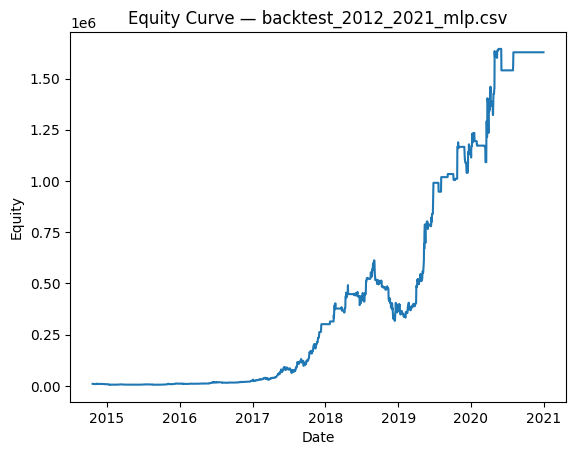

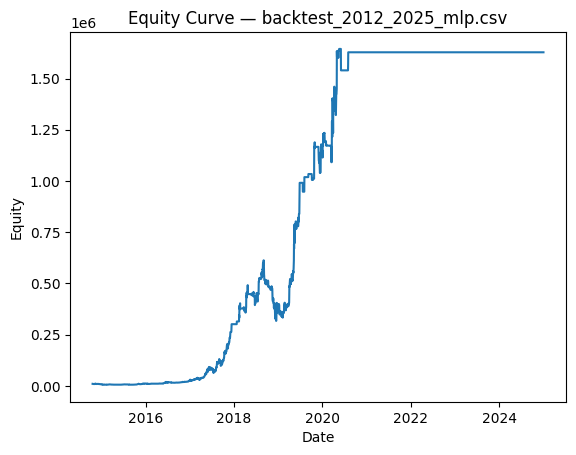

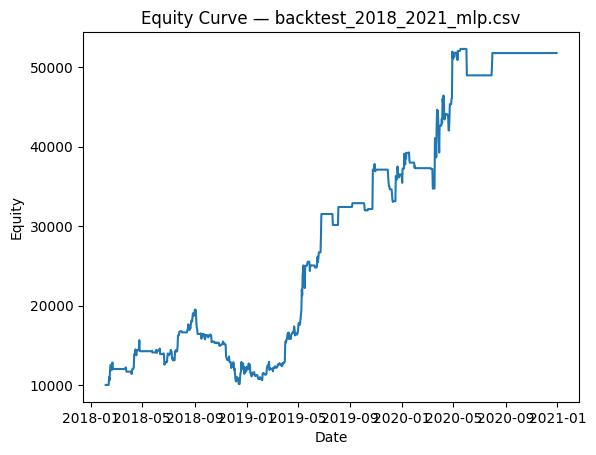

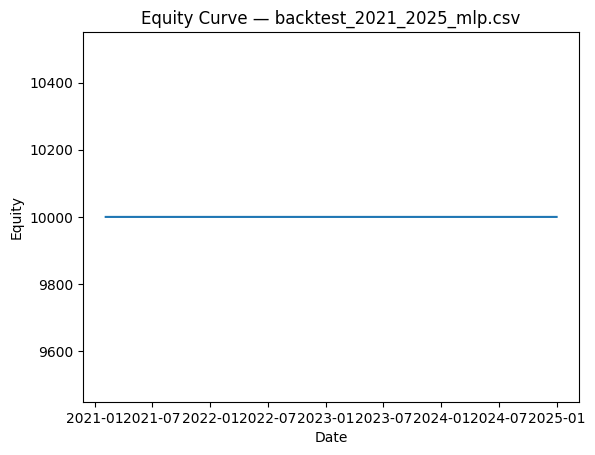

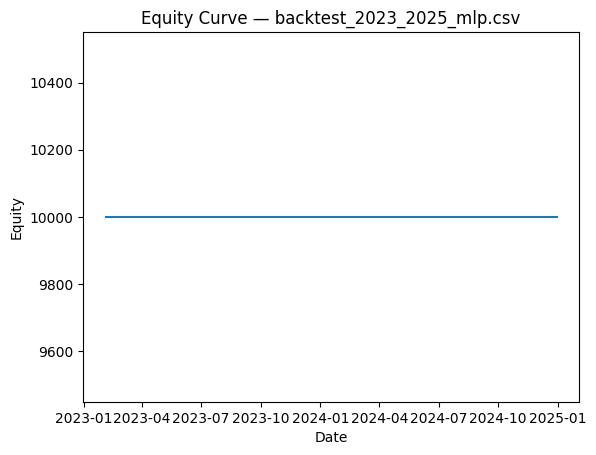

In [23]:
for name, df_bt in loaded.items():
    plt.figure()
    plt.plot(df_bt['Date'], df_bt['Equity'])
    plt.title(f'Equity Curve — {name}')
    plt.xlabel('Date')
    plt.ylabel('Equity')
    plt.show()


## 5) Notes / interpretation
- If Total Return, Sharpe and MaxDD are ~0, the policy likely stayed mostly **HOLD** (no meaningful trades).
- RL trading can be regime-dependent. Prefer multiple windows + walk-forward + multiple seeds for robust evaluation.


## 6) Export summary table (optional)

In [24]:
if len(results) > 0:
    summary_path = OUT_DIR / 'summary_mlp_backtests.csv'
    results.to_csv(summary_path, index=False)
    print('Wrote:', summary_path)


Wrote: /Users/alessandrofiaschini/Desktop/smart-trader-btc/versions/mlp/outputs/summary_mlp_backtests.csv
